In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Individuals on SSL by Latest Residential Police District

Other than the latest residential police district (LATEST_DIST_RES), all of the geographic information is about where the arrest itself occured. Looking at this can show both how many people on the list were not living in Chicago during their last arrest (listed as District 31), as well as the distribution of those inside the city.

In [3]:
ssl_df = pd.read_csv('data/Strategic_Subject_List.csv', dtype={'LATEST_DIST_RES': 'object'})
ssl_df.info(verbose=True)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398684 entries, 0 to 398683
Data columns (total 48 columns):
SSL_SCORE                                   398684 non-null int64
PREDICTOR_RAT_AGE_AT_LATEST_ARREST          398582 non-null object
PREDICTOR_RAT_VICTIM_SHOOTING_INCIDENTS     398684 non-null int64
PREDICTOR_RAT_VICTIM_BATTERY_OR_ASSAULT     398684 non-null int64
PREDICTOR_RAT_ARRESTS_VIOLENT_OFFENSES      398684 non-null int64
PREDICTOR_RAT_GANG_AFFILIATION              398684 non-null int64
PREDICTOR_RAT_NARCOTIC_ARRESTS              398684 non-null int64
PREDICTOR_RAT_TREND_IN_CRIMINAL_ACTIVITY    398684 non-null float64
PREDICTOR_RAT_UUW_ARRESTS                   398684 non-null int64
SEX_CODE_CD                                 398684 non-null object
RACE_CODE_CD                                398684 non-null object
WEAPON_I                                    398684 non-null object
DRUG_I                                      398684 non-null object
AGE_GROUP               

In [4]:
district_df = gpd.read_file('data/chi_police_districts.geojson')
district_df.info(verbose=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 3 columns):
dist_label    25 non-null object
dist_num      25 non-null object
geometry      25 non-null object
dtypes: object(3)
memory usage: 680.0+ bytes


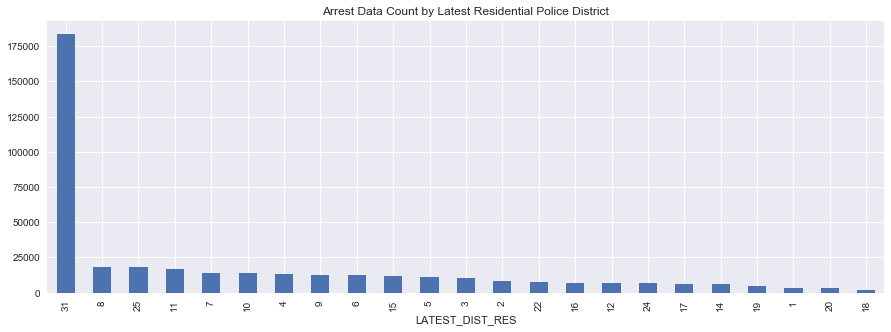

In [5]:
plt.rcParams["figure.figsize"] = [15, 5]

ssl_by_dist = ssl_df.groupby('LATEST_DIST_RES')['SSL_SCORE'].count()
ssl_by_dist.sort_values(ascending=False, inplace=True)
ssl_by_dist.plot(kind='bar', title='Arrest Data Count by Latest Residential Police District')

#### District Distribution

The largest group of any individuals in any district are in 31, with over 175,000. Police district 31 actually appears to represent areas outside of the city of Chicago, so we can merge drop that district and merge other records with the police districts in the city to see the distribution there.

In [11]:
ssl_by_dist_df = pd.DataFrame(ssl_by_dist).reset_index()
ssl_by_dist_df.columns = ['dist_num', 'ssl_count']

ssl_250_df = ssl_df.loc[ssl_df['SSL_SCORE'] >= 250].copy()
ssl_dist_250 = ssl_250_df.groupby('LATEST_DIST_RES')['SSL_SCORE'].count()
ssl_by_dist_250_df = pd.DataFrame(ssl_dist_250).reset_index()
ssl_by_dist_250_df.columns = ['dist_num', 'ssl_count']

district_df = district_df.loc[district_df['dist_num'] != '31']

district_df_merge = district_df.merge(ssl_by_dist_df, on='dist_num', how='left')
district_df_merge['ssl_count'].fillna(0, inplace=True)

district_df_250_merge = district_df.merge(ssl_by_dist_250_df, on='dist_num', how='left')
district_df_250_merge['ssl_count'].fillna(0, inplace=True)

district_df_merge.head()

,dist_label,dist_num,geometry,ssl_count
0,17TH,17,(POLYGON ((-87.71067089391354 41.9973656553694...,6306
1,20TH,20,(POLYGON ((-87.66029423572358 41.9909163385397...,2920
2,19TH,19,(POLYGON ((-87.64491798568677 41.9697270938148...,4393
3,25TH,25,(POLYGON ((-87.71739917372257 41.9392162133135...,17986
4,14TH,14,(POLYGON ((-87.69256666010364 41.9394265689430...,6233


## Police District Counts

While the police districts are too general to see any clear trends, there still seems to be a concentration of individuals on the SSL on the West and South sides.

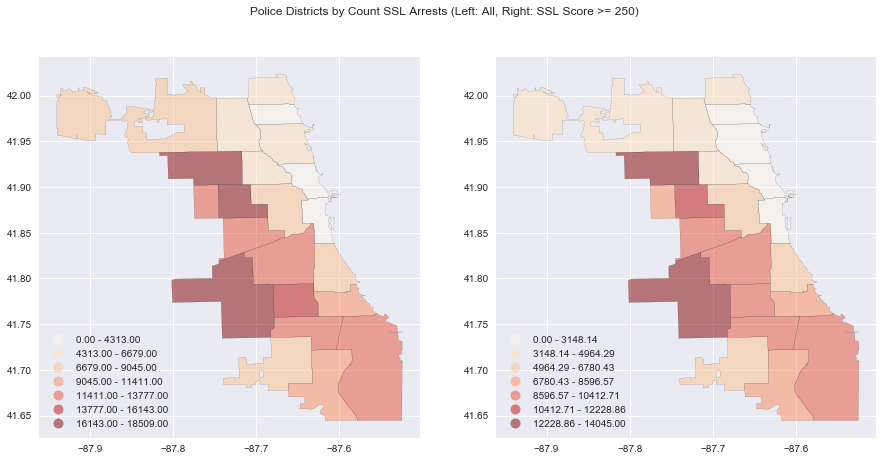

In [13]:
plt.rcParams["figure.figsize"] = [15, 7]
fig, axs = plt.subplots(1,2)

plt.suptitle('Police Districts by Count SSL Arrests (Left: All, Right: SSL Score >= 250)')

district_df_merge.plot(column='ssl_count', scheme='equal_interval', k=7, 
                       cmap='OrRd', ax=axs[0], linewidth=0.1, legend=True)
district_df_250_merge.plot(column='ssl_count', scheme='equal_interval', k=7, 
                           cmap='OrRd', ax=axs[1], linewidth=0.1, legend=True)